In [1]:
JUPYTER_ALLOW_INSECURE_WRITES=True
import os
import tempfile
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.transforms import AddChanneld, CenterSpatialCropd, Compose, Lambdad, LoadImaged, Resized, ScaleIntensityd
from monai.utils import set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset, random_split
import scipy
import io
import random
import math
import pandas as pd
from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler, DDIMScheduler
import numpy as np
import SimpleITK as sitk
import torchio as tio
import torch.nn as nn
sitk.ProcessObject.SetGlobalDefaultThreader("Platform")
from multiprocessing import Manager

from typing import Optional

import warnings
warnings.filterwarnings('ignore')
import os
JUPYTER_ALLOW_INSECURE_WRITES=True


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Set the CUDA_VISIBLE_DEVICES environment variable to specify the GPU device
os.environ['CUDA_VISIBLE_DEVICES'] = '2,3,5,6'
# Set the manualSeed, random seed, and device
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# It's recommended to set the global deterministic behavior of some libraries.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set the default number of threads for SimpleITK.
sitk.ProcessObject.SetGlobalDefaultThreader("Platform")

# Set the global behavior of SimpleITK to use the Platform multithreading.
# This is especially useful when using SimpleITK with multi-core systems.
sitk.ProcessObject.SetGlobalDefaultThreader("Platform")



# Replace 'path_to_your_nii_file.nii' with the actual path to your NIfTI image file


config = {
    'batch_size': 4,
    'imgDimResize':(160,192,160),
    'imgDimPad': (208, 256, 208),
    'spatialDims': '3D',
    'unisotropic_sampling': True, 
    'perc_low': 1, 
    'perc_high': 99,
    'rescaleFactor':1,
    'base_path': '/scratch1/akrami/Latest_Data/Data',
}




In [4]:
def sitk_reader(path):
                
    image_nii = sitk.ReadImage(str(path), sitk.sitkFloat32)
    vol = sitk.GetArrayFromImage(image_nii).transpose(2,1,0)
    return vol, None


def get_transform(cfg): # only transforms that are applied once before preloading
    exclude_from_resampling = None
    h, w, d = tuple(cfg.get('imgDimResize',(160,192,160)))
    if cfg.get('unisotropic_sampling',True):
        preprocess = tio.Compose([
        tio.CropOrPad((h,w,d),padding_mode=0),
        tio.RescaleIntensity((0, 1),percentiles=(cfg.get('perc_low',1),cfg.get('perc_high',99)),masking_method='mask'),
        tio.Resample(cfg.get('rescaleFactor',3.0),image_interpolation='bspline',exclude=exclude_from_resampling),#,exclude=['vol_orig','mask_orig','seg_orig']), # we do not want to resize *_orig volumes
        ])

    else: 
        preprocess = tio.Compose([
                tio.RescaleIntensity((0, 1),percentiles=(cfg.get('perc_low',1),cfg.get('perc_high',99))),
                tio.Resample(cfg.get('rescaleFactor',3.0),image_interpolation='bspline',exclude=exclude_from_resampling),#,exclude=['vol_orig','mask_orig','seg_orig']), # we do not want to resize *_orig volumes
            ])


    return preprocess


class DatasetCache(object):
    def __init__(self, manager, use_cache=True):
        self.use_cache = use_cache
        self.manager = manager
        self._dict = manager.dict()

    def is_cached(self, key):
        if not self.use_cache:
            return False
        return str(key) in self._dict

    def reset(self):
        self._dict.clear()

    def get(self, key):
        if not self.use_cache:
            raise AttributeError('Data caching is disabled and get funciton is unavailable! Check your config.')
        return self._dict[str(key)]

    def cache(self, key, subject):
        # only store if full data in memory is enabled
        if not self.use_cache:
            return
        # only store if not already cached
        if str(key) in self._dict:
            return
        self._dict[str(key)] = (subject)

class preload_wrapper(Dataset):
    def __init__(self,ds,cache,augment=None):
            self.cache = cache
            self.ds = ds
            self.augment = augment
    def reset_memory(self):
        self.cache.reset()
    def __len__(self):
            return len(self.ds)
            
    def __getitem__(self, index):
        if self.cache.is_cached(index) :
            subject = self.cache.get(index)
        else:
            subject = self.ds.__getitem__(index)
            self.cache.cache(index, subject)
        if self.augment:
            subject = self.augment(subject)
        return subject
    
class vol2slice(Dataset):
    def __init__(self,ds,cfg,onlyBrain=False,slice=None,seq_slices=None):
            self.ds = ds
            self.onlyBrain = onlyBrain
            self.slice = slice
            self.seq_slices = seq_slices
            self.counter = 0 
            self.ind = None
            self.cfg = cfg

    def __len__(self):
            return len(self.ds)
            
    def __getitem__(self, index):
        subject = self.ds.__getitem__(index)
        
        subject['vol'].data = subject['vol'].data.permute(0,3, 2, 1)
 
        return subject

def get_augment(cfg): # augmentations that may change every epoch
    augmentations = []

    # individual augmentations
    augment = tio.Compose(augmentations)
    return augment



In [5]:
def Train(csv,cfg,preload=True):
    subjects = []
    base_path = cfg.get('base_path',None)
    h, w, d = tuple(cfg.get('imgDimResize',(160,192,160)))
    for _, sub in csv.iterrows():
       # print(sub.img_path)
        subject_dict = {
            'vol' : tio.ScalarImage(sub.img_path, reader=sitk_reader), 
            'age' : sub.age,
            'ID' : sub.img_name,
            'path' : sub.img_path
        }

        if sub.mask_path != None: # if we have masks
            subject_dict['mask'] = tio.LabelMap(sub.mask_path,reader=sitk_reader)
        subject = tio.Subject(subject_dict)
        subjects.append(subject)
    
    if preload: 
        manager = Manager()
        cache = DatasetCache(manager)
        ds = tio.SubjectsDataset(subjects, transform = get_transform(cfg))
        ds = preload_wrapper(ds, cache, augment = get_augment(cfg))
    else: 
        ds = tio.SubjectsDataset(subjects, transform = tio.Compose([get_transform(cfg),get_augment(cfg)]))
        
    if cfg.get('spatialDims') == '2D':
        slice_ind = cfg.get('startslice',None) 
        seq_slices = cfg.get('sequentialslices',None) 
        ds = vol2slice(ds,cfg,slice=slice_ind,seq_slices=seq_slices)
    return ds





    # if cfg.mode == 't2': 
    #     var_csv[state] =var_csv[state][var_csv[state].img_name.isin(keep_t2['0'].str.replace('t2','t1'))]
    #     var_csv[state]['img_path'] = var_csv[state]['img_path'].str.replace('t1','t2')
    
def Eval(csv,cfg): 
    subjects = []
    for _, sub in csv.iterrows():
        if sub.mask_path is not None and tio.ScalarImage(sub.img_path,reader=sitk_reader).shape != tio.ScalarImage(sub.mask_path,reader=sitk_reader).shape:
            print(f'different shapes of vol and mask detected. Shape vol: {tio.ScalarImage(sub.img_path,reader=sitk_reader).shape}, shape mask: {tio.ScalarImage(sub.mask_path,reader=sitk_reader).shape} \nsamples will be resampled to the same dimension')
            
        # subject_dict = {
        #     'vol' : tio.ScalarImage(sub.img_path,reader=sitk_reader),
        #     'vol_orig' : tio.ScalarImage(sub.img_path,reader=sitk_reader), # we need the image in original size for evaluation
        #     'age' : sub.age,
        #     'ID' : sub.img_name,
        #     'label' : sub.label,
        #     'Dataset' : sub.setname,
        #     'stage' : sub.settype,
        #     'seg_available': False,
        #     'path' : sub.img_path }

        subject_dict = {
            'vol' : tio.ScalarImage(sub.img_path, reader=sitk_reader), 
            'seg' : tio.ScalarImage(sub.seg_path, reader=sitk_reader),
            'age' : sub.age,
            'ID' : sub.img_name,
            'path' : sub.img_path
        }
        if sub.mask_path != None: # if we have masks
            subject_dict['mask'] = tio.LabelMap(sub.mask_path,reader=sitk_reader)

        # if sub.seg_path != None: # if we have segmentations
        #     subject_dict['seg'] = tio.LabelMap(sub.seg_path,reader=sitk_reader),
        #     subject_dict['seg_orig'] = tio.LabelMap(sub.seg_path,reader=sitk_reader)# we need the image in original size for evaluation
        #     subject_dict['seg_available'] = True
        # if sub.mask_path != None: # if we have masks
        #     subject_dict['mask'] = tio.LabelMap(sub.mask_path,reader=sitk_reader)
        #     subject_dict['mask_orig'] = tio.LabelMap(sub.mask_path,reader=sitk_reader)# we need the image in original size for evaluation
        # else: 
        #     tens=tio.ScalarImage(sub.img_path,reader=sitk_reader).data>0
        #     subject_dict['mask'] = tio.LabelMap(tensor=tens)
        #     subject_dict['mask_orig'] = tio.LabelMap(tensor=tens)

        subject = tio.Subject(subject_dict)
        subjects.append(subject)
    ds = tio.SubjectsDataset(subjects, transform = get_transform(cfg))
    return ds






In [6]:
imgpath = {}
csvpath_train = '/acmenas/hakrami/patched-Diffusion-Models-UAD/Data/splits/IXI_train_fold0.csv'
pathBase = '/acmenas/hakrami/patched-Diffusion-Models-UAD/Data_train'
csvpath_val = '/acmenas/hakrami/patched-Diffusion-Models-UAD/Data/splits/IXI_val_fold0.csv'
csvpath_test = '/acmenas/hakrami/patched-Diffusion-Models-UAD/Data/splits/Brats21_sub_test.csv'
var_csv = {}
states = ['train','val','test']
var_csv['train'] = pd.read_csv(csvpath_train)
var_csv['val'] = pd.read_csv(csvpath_val)
var_csv['test'] = pd.read_csv(csvpath_test)
# if cfg.mode == 't2':
#     keep_t2 = pd.read_csv(cfg.path.IXI.keep_t2) # only keep t2 images that have a t1 counterpart

for state in states:
    var_csv[state]['settype'] = state
    var_csv[state]['img_path'] = pathBase  + var_csv[state]['img_path']
    var_csv[state]['mask_path'] = pathBase  + var_csv[state]['mask_path']
    if state!='test':
        var_csv[state]['seg_path'] = None

var_csv['test']['seg_path'] =  pathBase  + var_csv['test']['seg_path']
    
data_train = Train(var_csv['train'],config) 
data_val = Train(var_csv['val'],config)                
data_test = Eval(var_csv['test'],config)



#data_train = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_train_fold0.csv', converters={'img_path': pd.eval}), config)
train_loader = DataLoader(data_train, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=8)

#data_val = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_val_fold0.csv', converters={'img_path': pd.eval}), config)
val_loader = DataLoader(data_val, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=8)

#data_test = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/Brats21_test.csv', converters={'img_path': pd.eval}), config)
test_loader = DataLoader(data_test, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=8)


dict_keys(['vol', 'seg', 'age', 'ID', 'path', 'mask'])
tensor([    nan, 48.8250,     nan,     nan], dtype=torch.float64)
torch.Size([4, 1, 160, 192, 160])


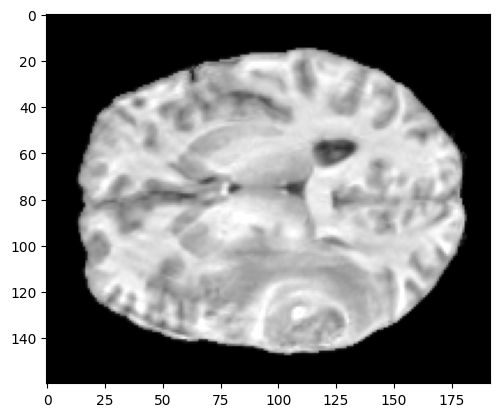

In [32]:
#s = next(iter(test_loader))
print(s.keys())
print(s['age'])
print(s['vol']['data'].size())
image_array = s['vol']['data']
global_vmin = torch.min(image_array).item() 
global_vmax = torch.max(image_array).item() 
plt.imshow(image_array[0][0][:,:,80].squeeze().cpu().numpy(), vmin=0, vmax=1,cmap='gray')

torch.Size([4, 1, 160, 192, 160])


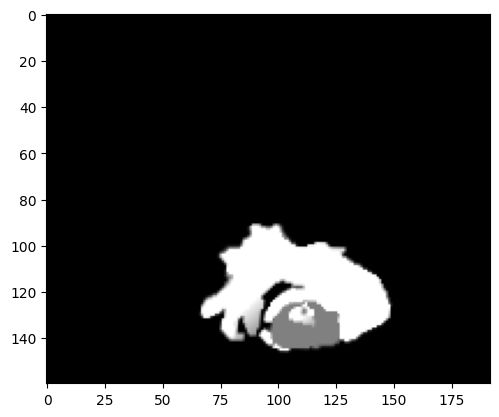

In [25]:

print(s['seg']['data'].size())
image_array_sclice= s['seg']['data'][0][0][:,:,80].squeeze().cpu().numpy()
plt.imshow(image_array_sclice, cmap='gray')

In [7]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    num_channels=[32, 64, 128, 128],
    attention_levels=[False, False, False,True],
    num_head_channels=[0, 0, 0,32],
    num_res_blocks=2,
)

model.to(device)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="scaled_linear_beta", beta_start=0.0005, beta_end=0.0195)

inferer = DiffusionInferer(scheduler)

optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-5)

Using 4 GPUs!


In [12]:
# specify your model filename
model_filename = '/acmenas/hakrami/3D_lesion_DF/models/test/model_epoch423.pt'

# load state_dict into the model
model.load_state_dict(torch.load(model_filename))

# if you need to set the model in evaluation mode
model.eval()

DataParallel(
  (module): DiffusionModelUNet(
    (conv_in): Convolution(
      (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (time_embed): Sequential(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 32, eps=1e-06, affine=True)
            (nonlinearity): SiLU()
            (conv1): Convolution(
              (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            )
            (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
            (norm2): GroupNorm(32, 32, eps=1e-06, affine=True)
            (conv2): Convolution(
              (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            )
 

## Sampling Brain Image

In order to sample the brain images, we need to pass the model an image containing just noise and use it to remove the noise of the image iteratively. For that, we will use the `.sample()` function of the `inferer`.

In [13]:

noise = torch.randn((1, 1, 160,192, 160))
noise = noise.to(device)
scheduler.set_timesteps(num_inference_steps=1000)
image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [06:20<00:00,  2.63it/s]


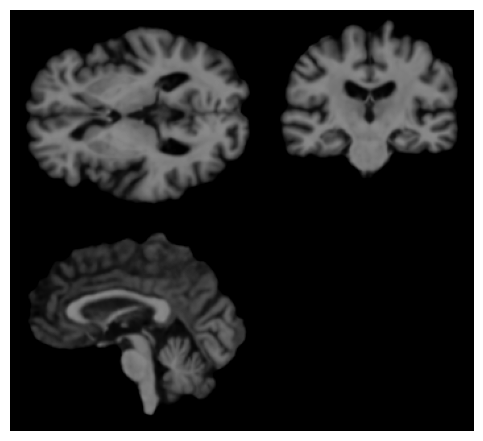

In [14]:
plt.style.use("default")
plotting_image_0 = np.concatenate([image[0, 0, :, :, 80].cpu(), np.flipud(image[0, 0, :, 96, :].cpu().T)], axis=1)
plotting_image_1 = np.concatenate([np.flipud(image[0, 0, 80, :, :].cpu().T), np.zeros((160, 160))], axis=1)
plt.imshow(np.concatenate([plotting_image_0, plotting_image_1], axis=0), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

In [15]:

import nibabel as nib
image_data = image.squeeze().cpu().numpy()

# Change datatype to float64 (optional, only if your data is not complex)
image_data = image_data.astype(np.float64)
nii_img = nib.Nifti1Image(image_data, np.eye(4))

# Save the image
nib.save(nii_img, 'test_image_bio.nii')

Shape of the NIfTI file 'test_image_bio.nii': (160, 192, 160)


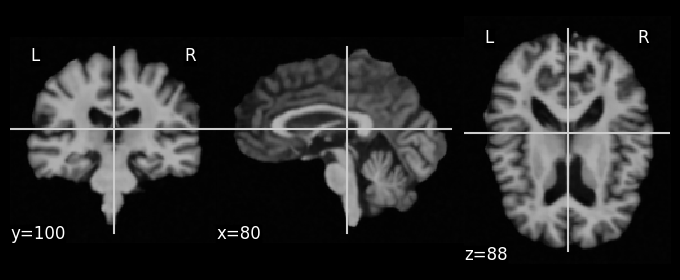

In [16]:
from nilearn.plotting import plot_anat
import nibabel as nib

def print_nifti_shape(file_path):
    try:
        # Load the NIfTI file
        nifti_img = nib.load(file_path)

        # Get the shape of the NIfTI data array
        data_shape = nifti_img.get_fdata().shape

        # Print the shape
        print(f"Shape of the NIfTI file '{file_path}': {data_shape}")
    except Exception as e:
        print(f"Error: {e}")

plot_anat("test_image_bio.nii")
# Replace 'your_nifti_file.nii' with the actual path to your NIfTI file
nifti_file_path = "test_image_bio.nii"
print_nifti_shape(nifti_file_path)


In [28]:
noise =torch.randn_like(image_array)
#for i in range(1000):
#noisy_img = scheduler.add_noise(original_samples=noisy_img, noise=noise, timesteps=torch.tensor(i))
noisy_img_v2 = scheduler.add_noise(original_samples=image_array, noise=noise, timesteps=torch.tensor(500))

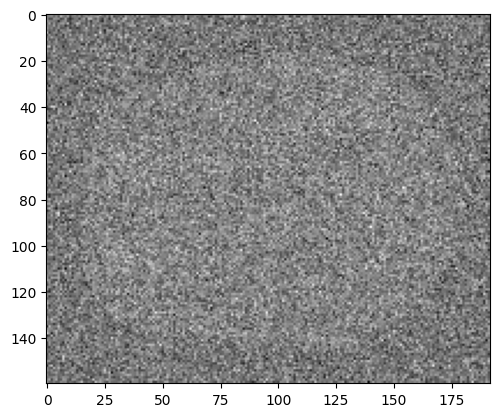

In [29]:

plt.imshow(noisy_img_v2[0][0][:,:,80].squeeze().cpu().numpy(), cmap='gray')

In [30]:
# scheduler.set_timesteps(num_inference_steps=90)
# with autocast(enabled=True):
#     decoded = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

# scheduler.set_timesteps(num_inference_steps=1000)
# image_xx = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)
# plt.rcParams['figure.figsize'] = (5, 5)
# plt.style.use("default")
# plt.imshow(image_xx[0][0][:,:,40].detach().cpu(), vmin=0, vmax=1, cmap="gray")
# plt.tight_layout()
# plt.axis("off")
# plt.show()

#noise = torch.randn((1, 1, 80, 96, 80))
noise = noisy_img_v2[0:1,:,:,:,:].to(device)
scheduler.set_timesteps(num_inference_steps=1000)
image_xx = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

100%|██████████| 1000/1000 [06:18<00:00,  2.64it/s]


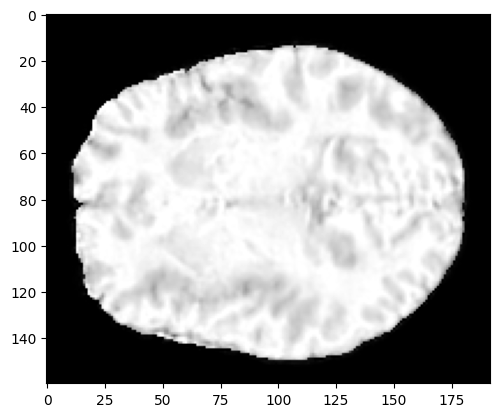

In [35]:


# Now when displaying any image:
#plt.imshow(diff_image[0][0][:,:,80].squeeze().cpu().numpy(), cmap='gray', vmin=global_vmin, vmax=global_vmax)
plt.imshow(image_xx[0][0][:,:,80].squeeze().cpu().numpy(),vmin=0, vmax=1, cmap='gray')

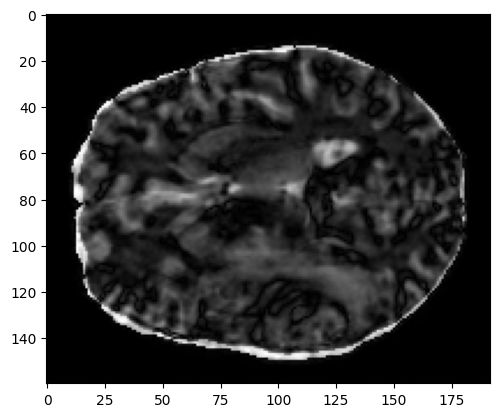

In [36]:
diff_image = torch.abs(image_xx.to(device)-image_array[0:1,:,:,:,:].to(device))
plt.imshow(diff_image[0][0][:,:,80].squeeze().cpu().numpy(),vmin=0, vmax=1, cmap='gray')

In [37]:
import nibabel as nib
image_data = image_xx.squeeze().cpu().numpy()

# Change datatype to float64 (optional, only if your data is not complex)
image_data = image_data.astype(np.float64)
nii_img = nib.Nifti1Image(image_data, np.eye(4))

# Save the image
nib.save(nii_img, 'test_brats_recon_image_2.nii')

In [38]:
import nibabel as nib
image_data = image_array.squeeze().cpu().numpy()

# Change datatype to float64 (optional, only if your data is not complex)
image_data = image_data.astype(np.float64)
nii_img = nib.Nifti1Image(image_data, np.eye(4))

# Save the image
nib.save(nii_img, 'test_brats_image_2.nii')

### Sampling with Denoising Diffusion Implicit Model Scheduler

Recent papers have proposed different ways to improve the sampling speed by using fewer steps in the denoising process. In this example, we are using a `DDIMScheduler` (from [Song et al. "Denoising Diffusion Implicit Models"](https://arxiv.org/abs/2010.02502)) to reduce the original number of steps from 1000 to 250.

In [ ]:
scheduler_ddim = DDIMScheduler(
    num_train_timesteps=1000, schedule="scaled_linear_beta", beta_start=0.0005, beta_end=0.0195, clip_sample=False
)

scheduler_ddim.set_timesteps(num_inference_steps=250)

model.eval()
noise = torch.randn((1, 1, 32, 40, 32))
noise = noise.to(device)

image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler_ddim)

In [ ]:
plt.style.use("default")
plotting_image_0 = np.concatenate([image[0, 0, :, :, 15].cpu(), np.flipud(image[0, 0, :, 20, :].cpu().T)], axis=1)
plotting_image_1 = np.concatenate([np.flipud(image[0, 0, 15, :, :].cpu().T), np.zeros((32, 32))], axis=1)
plt.imshow(np.concatenate([plotting_image_0, plotting_image_1], axis=0), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()